In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

#### STEP 1 ####

outer_dia = 180  # mm
wall_thick = 5   # mm

# Calculate inner diameter, radii, cross-sectional area, and moment of inertia
inner_dia = outer_dia - 2 * wall_thick
outer_rad = outer_dia / 2
inner_rad = inner_dia / 2
area_cross_section = math.pi * (outer_rad**2 - inner_rad**2)
moment_inertia = math.pi * (outer_rad**4 - inner_rad**4) / 4
section_modulus = moment_inertia / outer_rad

print(f"Cross-Sectional Area: {area_cross_section:.2f} mm²")
print(f"Moment of Inertia: {moment_inertia:.2f} mm⁴")
print(f"Section Modulus: {section_modulus:.2f} mm³")

Cross-Sectional Area: 2748.89 mm²
Moment of Inertia: 10531698.50 mm⁴
Section Modulus: 117018.87 mm³


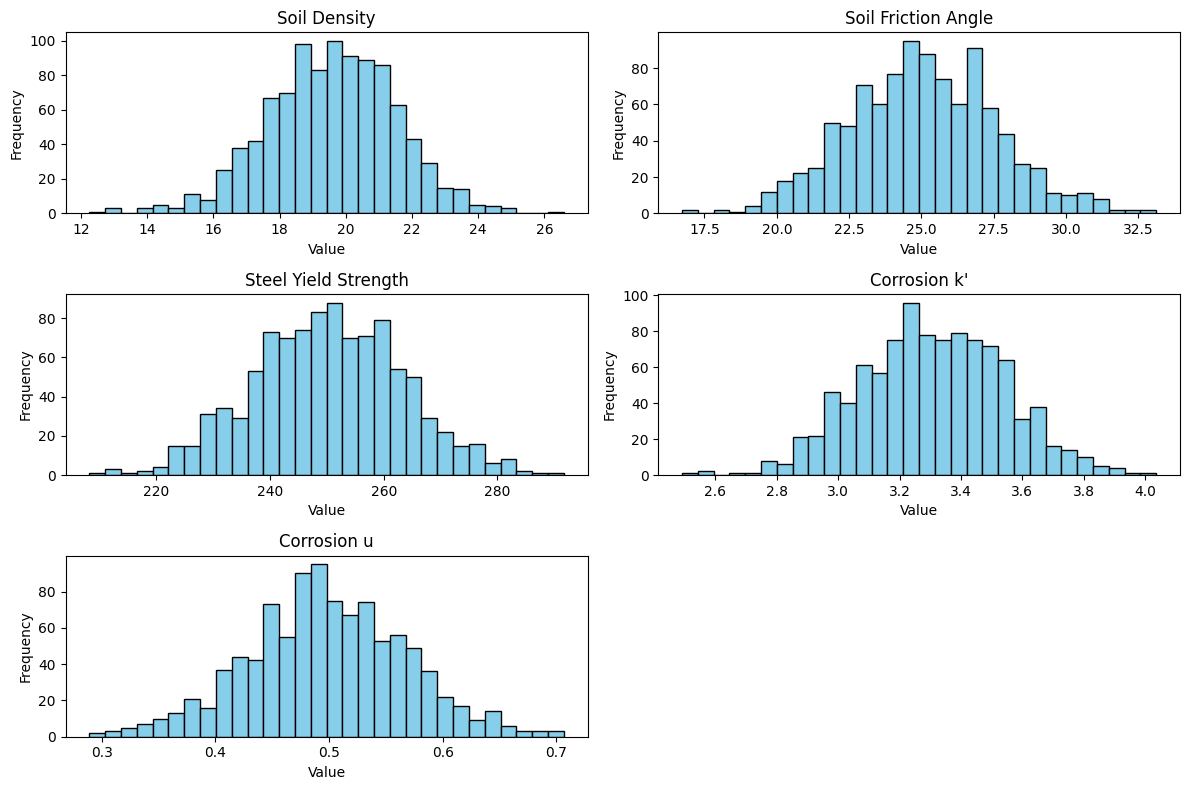

In [ ]:
# Step 2: Parameter Sampling for Soil, Steel, Corrosion Factors

# Define parameters with mean and COV values
params = {
    "Soil Density": (19.5, 0.1),
    "Soil Friction Angle": (25, 0.1),
    "Steel Yield Strength": (250, 0.05),
    "Corrosion k'": (3.3, 0.07),
    "Corrosion u": (0.5, 0.14),
}

num_samples = 1000
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Generate samples and plot histograms
for i, (param, (mean, cov)) in enumerate(params.items()):
    std_dev = mean * cov
    samples = np.random.normal(mean, std_dev, num_samples)
    ax = axs[i // 2, i % 2]
    ax.hist(samples, bins=30, color='skyblue', edgecolor='black')
    ax.set_title(param)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()

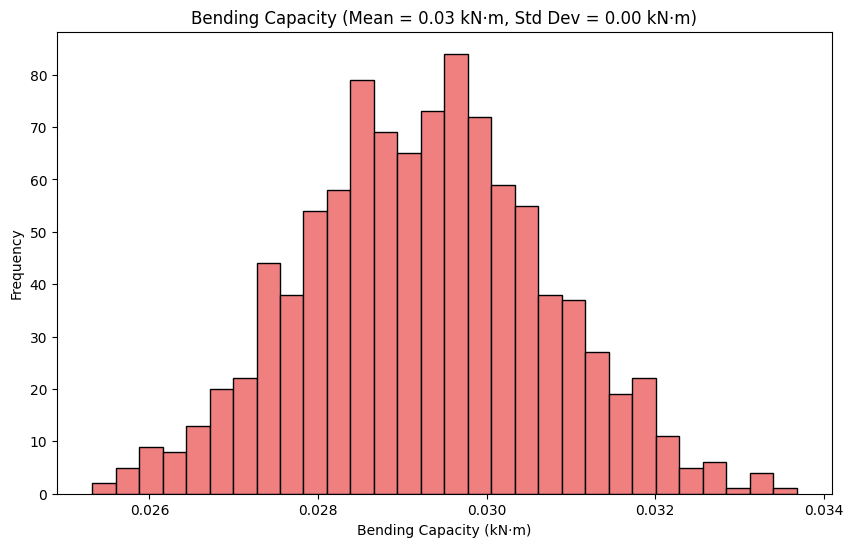

In [ ]:
# Step 3: Bending Capacity Calculation Based on Yield Strength

section_modulus_m3 = section_modulus * 1e-9
yield_samples = np.random.normal(250, 250 * 0.05, num_samples)
bending_capacity = yield_samples * section_modulus_m3

# Display bending capacity distribution
plt.figure(figsize=(10, 6))
plt.hist(bending_capacity, bins=30, color='lightcoral', edgecolor='black')
plt.title(f"Bending Capacity (Mean = {np.mean(bending_capacity):.2f} kN·m, Std Dev = {np.std(bending_capacity):.2f} kN·m)")
plt.xlabel("Bending Capacity (kN·m)")
plt.ylabel("Frequency")
plt.show()

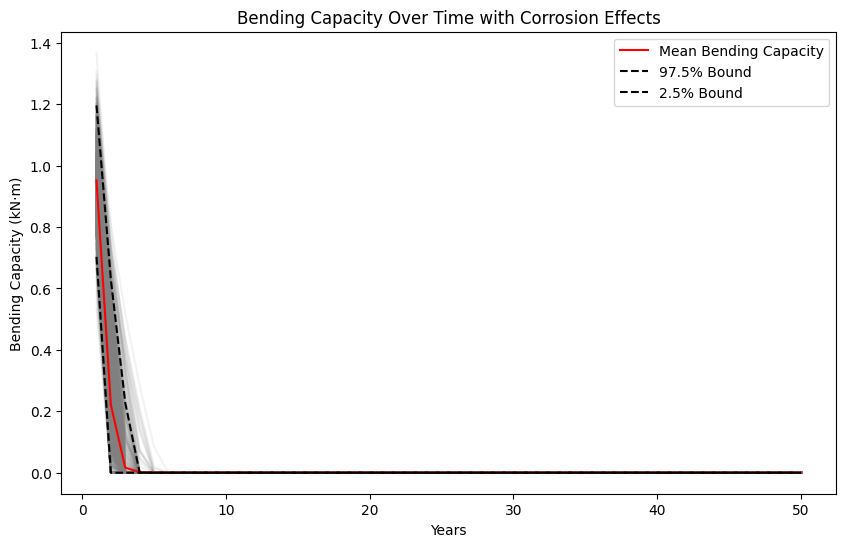

In [ ]:
# Step 4: Simulate Corrosion Effect on Thickness and Bending Capacity Over Time

corrosion_k_prime = 3.3
corrosion_u = 0.5
years = np.arange(1, 51)
simulations = 1000

k_prime_samples = np.random.normal(corrosion_k_prime, corrosion_k_prime * 0.07, simulations)
u_samples = np.random.normal(corrosion_u, corrosion_u * 0.14, simulations)

remaining_thickness = np.zeros((simulations, len(years)))
bending_capacity_over_time = np.zeros((simulations, len(years)))

for t in range(len(years)):
    # Thickness reduction due to corrosion
    thickness_loss = k_prime_samples * (years[t] ** u_samples)
    remaining_thickness[:, t] = np.maximum(wall_thick - thickness_loss, 0)

    # Calculate updated section modulus and bending capacity
    D_inner = outer_dia - 2 * remaining_thickness[:, t]
    section_modulus_t = (np.pi * (outer_dia ** 4 - D_inner ** 4) / 64) * 1e-9
    bending_capacity_over_time[:, t] = 250 * section_modulus_t

# Plot mean, upper, and lower bending capacity bounds over time
plt.figure(figsize=(10, 6))
mean_capacity = np.mean(bending_capacity_over_time, axis=0)
upper_bound = np.percentile(bending_capacity_over_time, 97.5, axis=0)
lower_bound = np.percentile(bending_capacity_over_time, 2.5, axis=0)

for sim in range(simulations):
    plt.plot(years, bending_capacity_over_time[sim, :], color='grey', alpha=0.1)

plt.plot(years, mean_capacity, color='red', label='Mean Bending Capacity')
plt.plot(years, upper_bound, 'k--', label='97.5% Bound')
plt.plot(years, lower_bound, 'k--', label='2.5% Bound')
plt.xlabel('Years')
plt.ylabel('Bending Capacity (kN·m)')
plt.title('Bending Capacity Over Time with Corrosion Effects')
plt.legend()
plt.show()

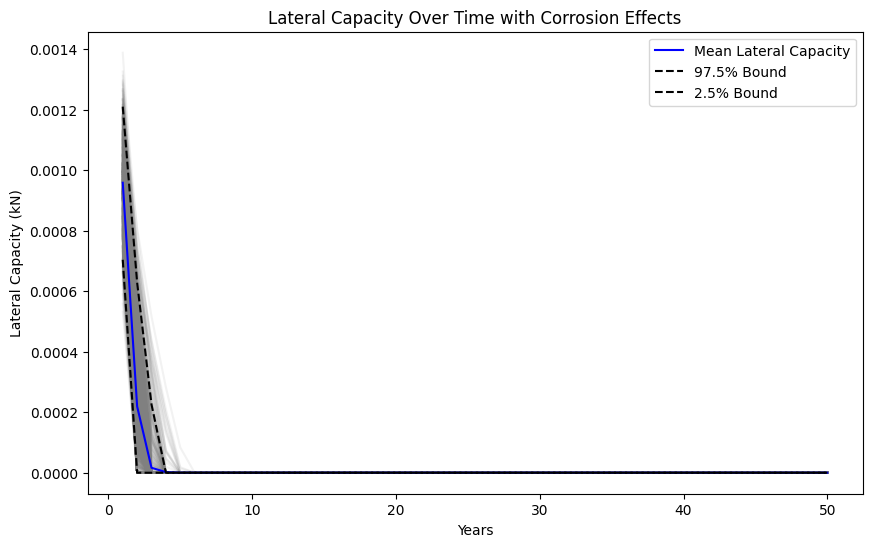

In [ ]:
# Step 5: Calculate Lateral Capacity Over Time

initial_force_kN = 1.0
lateral_capacity = np.zeros((simulations, len(years)))

for t in range(len(years)):
    # Effective area based on remaining thickness
    current_thickness = remaining_thickness[:, t]
    effective_area = np.pi * (outer_dia**2 - (outer_dia - 2 * current_thickness)**2) / 4 * 1e-6
    lateral_capacity[:, t] = initial_force_kN * effective_area

# Plot mean, upper, and lower bounds of lateral capacity over time
plt.figure(figsize=(10, 6))
mean_lateral = np.mean(lateral_capacity, axis=0)
upper_bound_lat = np.percentile(lateral_capacity, 97.5, axis=0)
lower_bound_lat = np.percentile(lateral_capacity, 2.5, axis=0)

for sim in range(simulations):
    plt.plot(years, lateral_capacity[sim, :], color='grey', alpha=0.1)

plt.plot(years, mean_lateral, color='blue', label='Mean Lateral Capacity')
plt.plot(years, upper_bound_lat, 'k--', label='97.5% Bound')
plt.plot(years, lower_bound_lat, 'k--', label='2.5% Bound')
plt.xlabel('Years')
plt.ylabel('Lateral Capacity (kN)')
plt.title('Lateral Capacity Over Time with Corrosion Effects')
plt.legend()
plt.show()

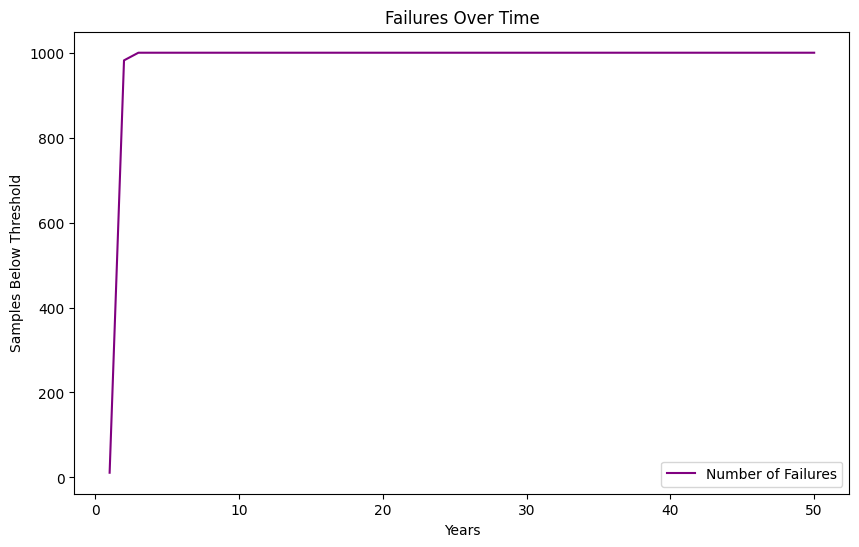

In [ ]:
# Step 6: Analyze Failure Threshold

failure_threshold = 0.7 * mean_capacity[0]  # 70% of initial bending capacity
failure_count = np.sum(bending_capacity_over_time < failure_threshold, axis=0)

# Plot failure count over time
plt.figure(figsize=(10, 6))
plt.plot(years, failure_count, color='purple', label='Number of Failures')
plt.xlabel('Years')
plt.ylabel('Samples Below Threshold')
plt.title('Failures Over Time')
plt.legend()
plt.show()